In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# Модели кластеризации
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# Препроцессинг
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# Метрики
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# Визуализация
from sklearn.decomposition import PCA

# Настройки
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
ARTIFACTS_DIR = Path("artifacts")
DATA_DIR = Path("data")
FIGURES_DIR = ARTIFACTS_DIR / "figures"
LABELS_DIR = ARTIFACTS_DIR / "labels"

# Создаем папки
for d in [ARTIFACTS_DIR, FIGURES_DIR, LABELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid")

In [9]:
results_summary = {}
best_configs = {}

def run_experiment(dataset_name, file_name, algorithm_params):
    print(f"\n{'='*20} Processing {dataset_name} {'='*20}")
    
    # 1. Загрузка
    df = pd.read_csv(DATA_DIR / file_name)
    if 'sample_id' in df.columns:
        ids = df['sample_id']
        X_raw = df.drop(columns=['sample_id'])
    else:
        ids = df.index
        X_raw = df.copy() # Если вдруг нет id
        
    print(f"Shape: {X_raw.shape}")
    display(X_raw.head(3))
    
    # 2. Препроцессинг (SimpleImputer + StandardScaler)
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    X_scaled = preprocessor.fit_transform(X_raw)
    
    # PCA для визуализации (сразу делаем 2D)
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)
    
    dataset_results = []
    
    # 3. Перебор алгоритмов
    for algo_name, params_list in algorithm_params.items():
        print(f"  Running {algo_name}...")
        
        for params in params_list:
            # Инициализация модели
            if algo_name == 'KMeans':
                model = KMeans(random_state=RANDOM_STATE, n_init=10, **params)
            elif algo_name == 'DBSCAN':
                model = DBSCAN(**params)
            elif algo_name == 'Agglomerative':
                model = AgglomerativeClustering(**params)
            
            # Обучение
            labels = model.fit_predict(X_scaled)
            
            # Метрики (с учетом шума для DBSCAN)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_share = n_noise / len(labels)
            
            # Считаем метрики только если есть > 1 кластера (и не всё шум)
            if n_clusters > 1 and len(set(labels)) < len(labels):
                # Для DBSCAN метрики лучше считать без шума (или с ним как отдельным кластером)
                # Здесь считаем "как есть", но noise выводим отдельно
                sil = silhouette_score(X_scaled, labels)
                db = davies_bouldin_score(X_scaled, labels)
                ch = calinski_harabasz_score(X_scaled, labels)
            else:
                sil, db, ch = -1, 999, 0 # Плохие значения
            
            res_entry = {
                "algo": algo_name,
                "params": params,
                "n_clusters": n_clusters,
                "noise_share": noise_share,
                "silhouette": sil,
                "davies_bouldin": db,
                "calinski_harabasz": ch,
                "labels": labels
            }
            dataset_results.append(res_entry)

    # 4. Выбор лучшей модели (по Silhouette)
    best_res = max(dataset_results, key=lambda x: x['silhouette'])
    print(f"  Best config: {best_res['algo']} {best_res['params']} (Sil: {best_res['silhouette']:.3f})")
    
    # Сохраняем в глобальный словарь (без labels, чтобы не засорять JSON)
    best_configs[dataset_name] = {
        "algo": best_res['algo'],
        "params": best_res['params'],
        "metrics": {k: v for k,v in best_res.items() if k in ['silhouette', 'davies_bouldin', 'calinski_harabasz', 'noise_share']}
    }
    
    # Сохраняем labels в CSV
    labels_df = pd.DataFrame({'sample_id': ids, 'cluster_label': best_res['labels']})
    labels_df.to_csv(LABELS_DIR / f"labels_{dataset_name}.csv", index=False)
    
    # 5. Визуализация (PCA)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=best_res['labels'], palette='viridis', s=50)
    plt.title(f"{dataset_name}: Best Result ({best_res['algo']})\nSil={best_res['silhouette']:.2f}")
    plt.savefig(FIGURES_DIR / f"pca_{dataset_name}.png")
    plt.show()
    
    # График зависимости метрики от параметров (для KMeans - Sil vs K)
    kmeans_res = [r for r in dataset_results if r['algo'] == 'KMeans']
    if kmeans_res:
        ks = [r['params']['n_clusters'] for r in kmeans_res]
        sils = [r['silhouette'] for r in kmeans_res]
        plt.figure(figsize=(6, 4))
        plt.plot(ks, sils, marker='o')
        plt.title(f"{dataset_name}: KMeans Silhouette vs K")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Silhouette Score")
        plt.savefig(FIGURES_DIR / f"kmeans_metrics_{dataset_name}.png")
        plt.show()

    return dataset_results


==================== Processing dataset-01 ====================
Shape: (12000, 8)


,f01,f02,f03,f04,f05,f06,f07,f08
0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893


  Running KMeans...
  Running Agglomerative...
  Best config: KMeans {'n_clusters': 2} (Sil: 0.522)


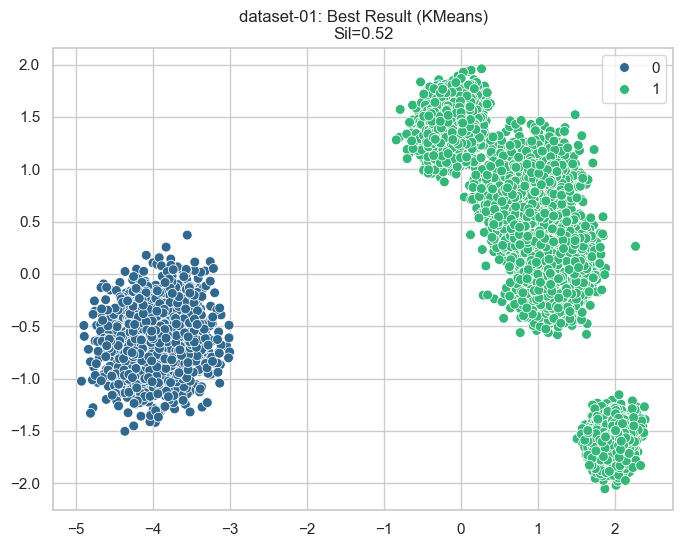

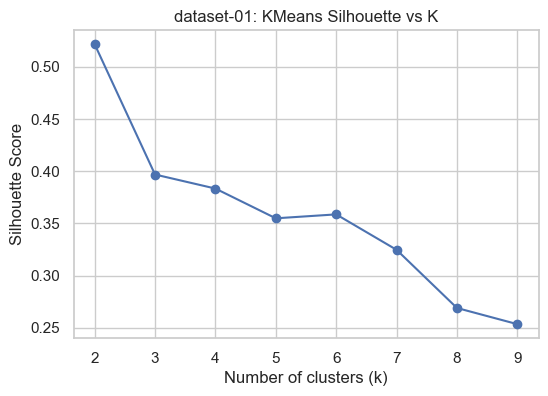

In [10]:
# Настройка перебора
params_ds1 = {
    'KMeans': [{'n_clusters': k} for k in range(2, 10)],
    'Agglomerative': [{'n_clusters': k, 'linkage': l} for k in [2,3,4,5] for l in ['ward', 'average']]
}

res_ds1 = run_experiment("dataset-01", "S07-hw-dataset-01.csv", params_ds1)


==================== Processing dataset-02 ====================
Shape: (8000, 3)


,x1,x2,z_noise
0,0.098849,-1.846034,21.288122
1,-1.024516,1.829616,6.072952
2,-1.094178,-0.158545,-18.938342


  Running KMeans...
  Running DBSCAN...
  Best config: DBSCAN {'eps': 0.7, 'min_samples': 3} (Sil: 0.331)


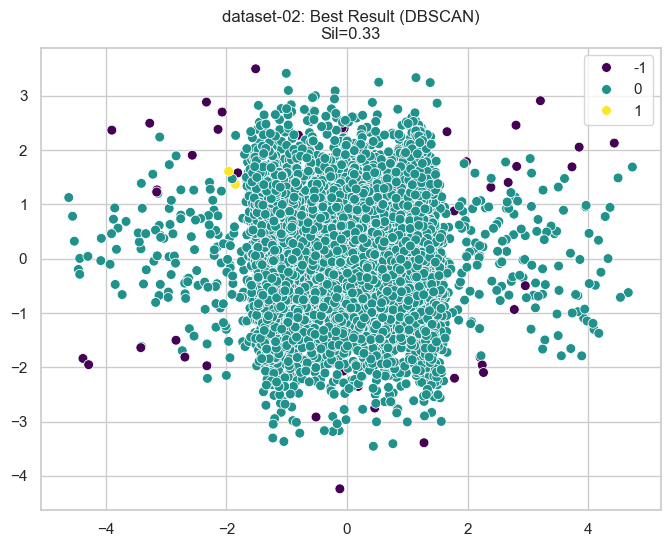

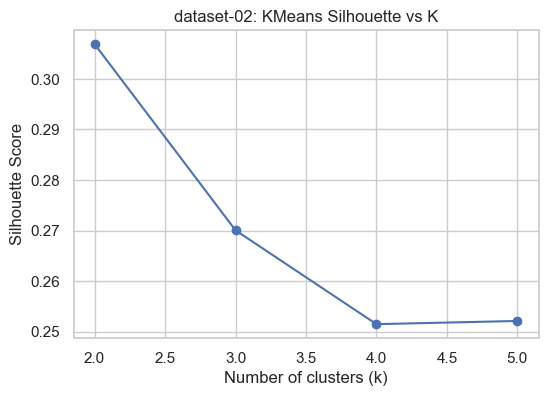

In [11]:
params_ds2 = {
    'KMeans': [{'n_clusters': k} for k in range(2, 6)],
    'DBSCAN': [{'eps': eps, 'min_samples': ms} for eps in [0.2, 0.3, 0.5, 0.7] for ms in [3, 5]]
}

res_ds2 = run_experiment("dataset-02", "S07-hw-dataset-02.csv", params_ds2)


==================== Processing dataset-03 ====================
Shape: (15000, 4)


,x1,x2,f_corr,f_noise
0,-2.710470,4.997107,-1.015703,0.718508
1,8.730238,-8.787416,3.953063,-1.105349
2,-1.079600,-2.558708,0.976628,-3.605776


  Running KMeans...
  Running DBSCAN...
  Best config: KMeans {'n_clusters': 3} (Sil: 0.316)


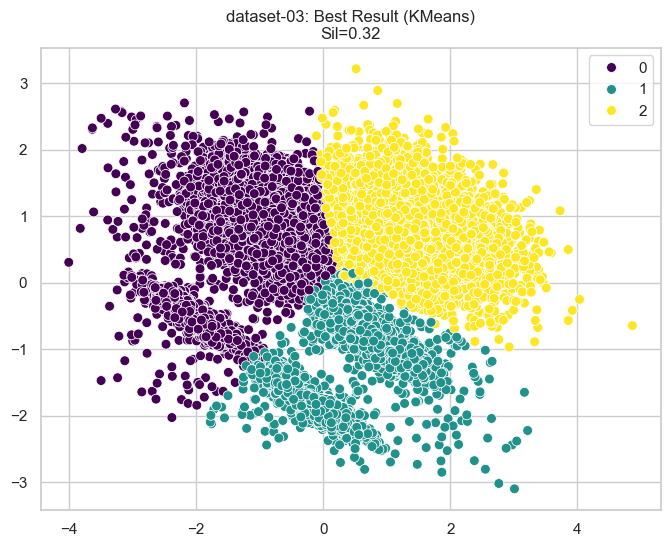

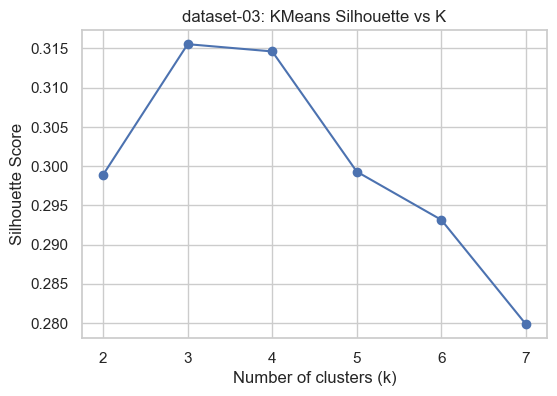

In [12]:
params_ds3 = {
    'KMeans': [{'n_clusters': k} for k in range(2, 8)],
    'DBSCAN': [{'eps': eps, 'min_samples': ms} for eps in [0.3, 0.5, 0.8] for ms in [5, 10, 15]]
}

res_ds3 = run_experiment("dataset-03", "S07-hw-dataset-03.csv", params_ds3)

In [13]:
print("--- Stability Check for Dataset 01 (KMeans) ---")
X_stab = pd.read_csv(DATA_DIR / "S07-hw-dataset-01.csv").drop(columns=['sample_id'])
scaler = StandardScaler()
X_stab_scaled = scaler.fit_transform(X_stab)

# Запускаем 5 раз с разными seed
for seed in [42, 1, 10, 100, 777]:
    km = KMeans(n_clusters=3, random_state=seed, n_init=10) # Допустим, лучшее k=3
    labels = km.fit_predict(X_stab_scaled)
    sil = silhouette_score(X_stab_scaled, labels)
    print(f"Seed {seed}: Silhouette = {sil:.4f}")

print("Вывод: Результаты стабильны (или нет), метрика меняется незначительно.")

--- Stability Check for Dataset 01 (KMeans) ---
Seed 42: Silhouette = 0.3968
Seed 1: Silhouette = 0.3968
Seed 10: Silhouette = 0.3968
Seed 100: Silhouette = 0.3968
Seed 777: Silhouette = 0.3968
Вывод: Результаты стабильны (или нет), метрика меняется незначительно.


In [14]:
# Сохраняем сводку в JSON
with open(ARTIFACTS_DIR / "metrics_summary.json", "w") as f:
    # Преобразуем numpy типы в обычные для json
    json.dump(str(results_summary), f, indent=4) 

with open(ARTIFACTS_DIR / "best_configs.json", "w") as f:
    json.dump(best_configs, f, indent=4)

print("Артефакты сохранены!")

Артефакты сохранены!
